#### IMPORTAR LIBRERIAS

In [1]:
import folium
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.preprocessing import LabelEncoder

#### CARGAR DATASETS

In [2]:
df_hechos = pd.read_parquet(r'C:\PROYECTO-INDIVIDUAL-2\Data\parquet\hechos.parquet')
df_victimas = pd.read_parquet(r'C:\PROYECTO-INDIVIDUAL-2\Data\parquet\victimas.parquet')

#### HACEMOS UN MERGE DE LOS DOS PARA FACILITAR EL ANALISIS

In [3]:
df_hv = pd.merge(df_victimas, df_hechos, on='id_hecho', how='left')

In [4]:
df_hv.head()

,id_hecho,fecha_x,rol,vehiculo_victima_x,sexo,edad,fecha_falleciomiento,cantidad_victimas,fecha_y,hora,lugar,tipo_de_calle,comuna,longitud,latitud,vehiculo_victima_y,vehiculo_acusado
0,2016-0001,2016-01-01,CONDUCTOR,MOTO,MASCULINO,19.0,2016-01-01,1,2016-01-01,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,8.0,-58.47533969,-34.68757022,MOTO,AUTO
1,2016-0002,2016-01-02,CONDUCTOR,AUTO,MASCULINO,70.0,2016-01-02,1,2016-01-02,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,9.0,-58.50877521,-34.66977709,AUTO,PASAJEROS
2,2016-0003,2016-01-03,CONDUCTOR,MOTO,MASCULINO,30.0,2016-01-03,1,2016-01-03,7,AV ENTRE RIOS 2034,AVENIDA,1.0,-58.39040293,-34.63189362,MOTO,AUTO
3,2016-0004,2016-01-10,CONDUCTOR,MOTO,MASCULINO,18.0,None,1,2016-01-10,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,8.0,-58.46503904,-34.68092974,MOTO,SD
4,2016-0005,2016-01-21,CONDUCTOR,MOTO,MASCULINO,29.0,2016-02-01,1,2016-01-21,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,1.0,-58.38718297,-34.62246630,MOTO,PASAJEROS


#### DROPEAMOS COLUMNAS QUE TIENEN LA MISMA INFO Y PONEMOS LOS NOMBRES COMO ESTABAN

In [5]:
df_hv.drop(columns=['fecha_y', 'vehiculo_victima_y'], inplace=True)
Actuales = df_hv.columns
Nuevas = ['id_hecho', 'fecha', 'rol', 'vehiculo_victima', 'sexo', 
       'edad', 'fecha_fallecimiento', 'cantidad_victimas', 'hora', 'lugar', 'tipo_de_calle', 'comuna', 'longitud', 'latitud', 'vehiculo_acusado']

columnas = {Actuales: Nuevas for (Actuales, Nuevas) in zip(Actuales, Nuevas)}
df_hv.rename(columns=columnas, inplace=True)

In [6]:
df_hv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id_hecho             717 non-null    object        
 1   fecha                717 non-null    datetime64[ns]
 2   rol                  717 non-null    object        
 3   vehiculo_victima     717 non-null    object        
 4   sexo                 717 non-null    object        
 5   edad                 664 non-null    float64       
 6   fecha_fallecimiento  649 non-null    object        
 7   cantidad_victimas    717 non-null    int64         
 8   hora                 716 non-null    Int64         
 9   lugar                717 non-null    object        
 10  tipo_de_calle        717 non-null    object        
 11  comuna               715 non-null    float64       
 12  longitud             717 non-null    object        
 13  latitud              717 non-null  

In [7]:
df_hv.duplicated().sum()

0

#### LO EXPORTAMOS COMO CSV PARA UTILIZARLO EN POWER BI

In [8]:
df_hv.to_csv(r'C:\PROYECTO-INDIVIDUAL-2\Data\csv\merged.csv', index=False)

#### TOTAL DE ACCIDENTES

In [9]:
print("El total de homicidios del 2016 al 2021 son: ", df_hv['id_hecho'].nunique())

El total de homicidios del 2016 al 2021 son:  696


#### DATOS GEOESPACIALES

In [10]:
# Tratamiento de los datos contenidos en las columnas 'latitud' y 'longitud' 
df_hv['latitud'] = pd.to_numeric(df_hv['latitud'], errors='coerce')
df_hv['latitud'] = df_hv['latitud'].replace('.', pd.NA, regex=True)
df_hv['longitud'] = pd.to_numeric(df_hv['longitud'], errors='coerce')
df_hv['longitud'] = df_hv['longitud'].replace('.', pd.NA, regex=True)

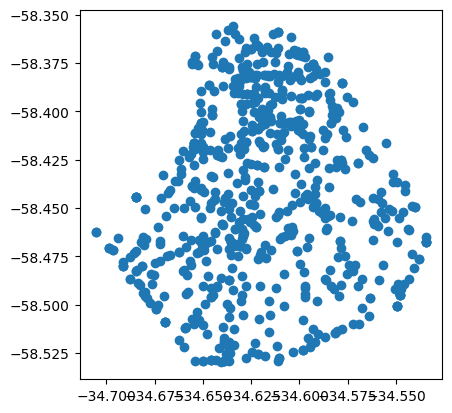

In [11]:
# Creación de la columna 'localizador' para almacenar las coordenadas: 'latitud', 'longitud'
df_hv['localizador'] = df_hv.apply(lambda row: f"{row['latitud']}, {row['longitud']}", axis=1)

# Conversión de coordenadas a elementos tipo Point
df_hv['geometry'] = df_hv['localizador'].apply(lambda x: Point(map(float, x.split(', '))))
df_vhgeolocalizador = gpd.GeoDataFrame(df_hv, geometry='geometry')
df_vhgeolocalizador.plot()
plt.show()

In [12]:
# Cálcula del promedio  de 'latitud' y 'longitud' para localizar geográficamente el mapa
lat_c = df_hv['latitud'].mean()
lon_c = df_hv['longitud'].mean()

# Generación del mapa
m = folium.Map(location=[lat_c, lon_c], zoom_start=11.5)

# Iteración sobre el DataFrame para definir coordenadas válidas
count = 0
for index, row in df_hv.iterrows():
    coordinates = row['localizador']  
    if pd.notnull(coordinates):
        lat, lon = coordinates.split(', ')
        try:
            lat, lon = float(lat), float(lon)
            folium.Marker(location=[lat, lon]).add_to(m)
        except ValueError:
            # Conteo del número de coordenadas geoespaciales inválidas
            count += 1                                          
               
print("El número de coordenadas geoespaciales inválidas es --->", count)

m

El número de coordenadas geoespaciales inválidas es ---> 13


#### VICTIMAS POR AÑO

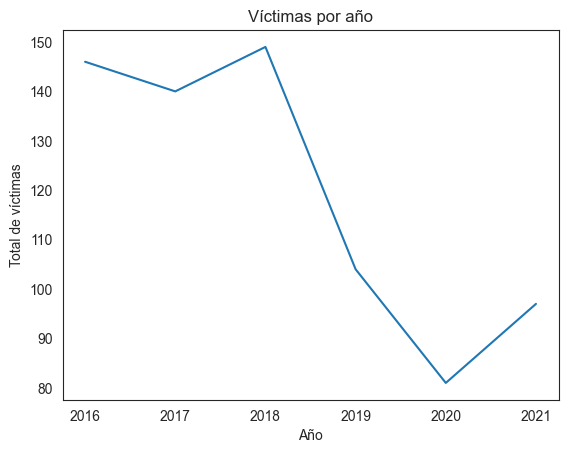

In [13]:
# Se calcula el número de homicidios por año
homicidios_por_anio = df_hv.groupby(df_hv['fecha'].dt.year)['fecha'].size()

# Se grafica el total de homicidios por año utilizando Seaborn
sns.set_style("white")
sns.lineplot(x=homicidios_por_anio.index, y=homicidios_por_anio.values)
plt.title('Víctimas por año')
plt.xlabel('Año')
plt.ylabel('Total de víctimas')
plt.show()

##### PODEMOS OBSERVAR EN EL GRAFICO QUE EN 2020 EXISTE UN MINIMO, SUPONEMOS QUE ES DEBIDO A LA CUARENTENA POR EL COVID-19

#### VICTIMAS POR FRANJA HORARIA

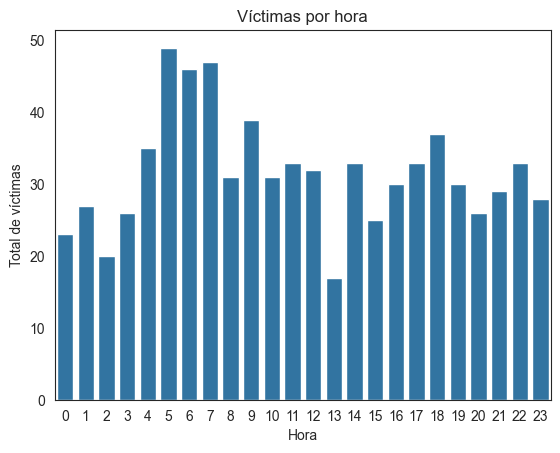

In [14]:
# Se calcula el número de homicidios por hora
homicidios_por_hora = df_hv.groupby('hora')['cantidad_victimas'].sum().reset_index(name='total_homicidios')

sns.set_style("white")
sns.barplot(x=homicidios_por_hora.index, y=homicidios_por_hora['total_homicidios'].values)
plt.title('Víctimas por hora')
plt.xlabel('Hora')
plt.ylabel('Total de víctimas')
plt.show()

#### LO VEMOS EN UN TOP PARA APRECIAR MEJOR

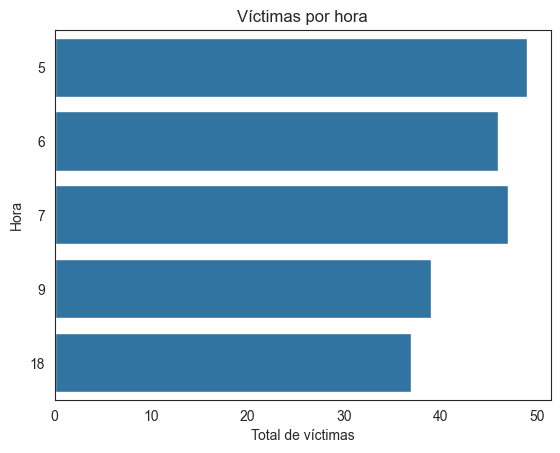

In [15]:
top_5_horas = homicidios_por_hora.nlargest(5, 'total_homicidios')

sns.set_style("white")
sns.barplot(x=top_5_horas['total_homicidios'], y=top_5_horas['hora'], orient='h')
plt.title('Víctimas por hora')
plt.xlabel('Total de víctimas')
plt.ylabel('Hora')
plt.show()

#### VICTIMAS POR MES

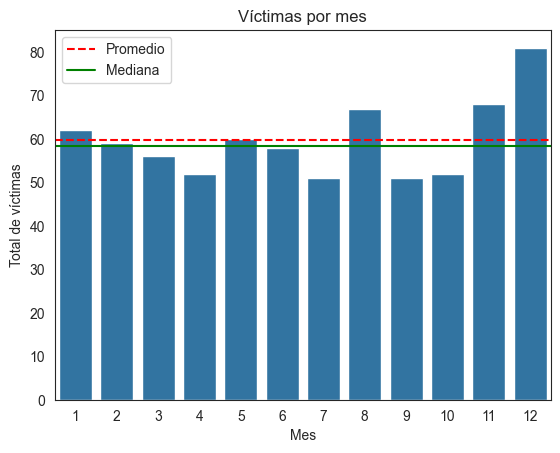

In [16]:
homicidios_por_mes = df_hv.groupby(df_hv['fecha'].dt.month)['fecha'].size()

sns.set_style("white")
sns.barplot(x=homicidios_por_mes.index, y=homicidios_por_mes.values)

promedio = homicidios_por_mes.mean()
mediana = homicidios_por_mes.median()
plt.axhline(promedio, color='red', linestyle='--', label='Promedio')
plt.axhline(mediana, color='green', linestyle='-', label='Mediana')

plt.title('Víctimas por mes')
plt.xlabel('Mes')
plt.ylabel('Total de víctimas')
plt.legend()
plt.show()

#### OBSERVACIONES
* Se aprecia que el mes con más víctimas es diciembre, época de fiestas, se puede suponer que hay mas movimientos en las calles y además la gente viaja mucho más.

#### VICTIIMAS POR DIA DE LA SEMANA

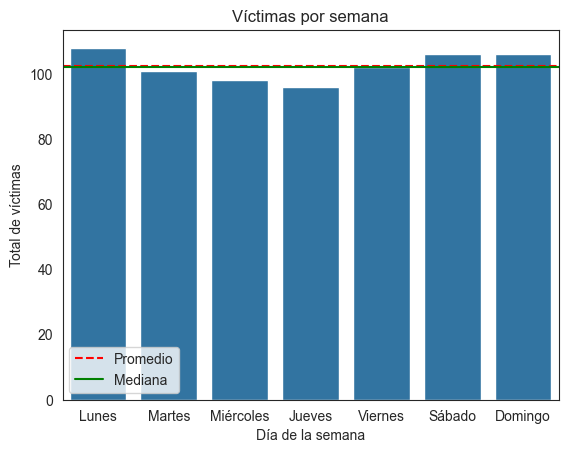

In [18]:
# Se calcula el número de homicidios por día
homicidios_por_dia = df_hv.groupby(df_hv['fecha'].dt.dayofweek)['fecha'].size()
dias_semana = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
homicidios_por_dia.index = homicidios_por_dia.index.map(dias_semana)

sns.set_style("white")
sns.barplot(x=homicidios_por_dia.index, y=homicidios_por_dia.values)

promedio = homicidios_por_dia.mean()
mediana = homicidios_por_dia.median()
plt.axhline(promedio, color='red', linestyle='--', label='Promedio')
plt.axhline(mediana, color='green', linestyle='-', label='Mediana')

plt.title('Víctimas por semana')
plt.xlabel('Día de la semana')
plt.ylabel('Total de víctimas')
plt.legend()
plt.show()

#### OBSERVACIONES
* Se aprecia que los acidentes viales con victimas ocurren con mas frecuencia entre las 6 y 7 de la madrugada los dias Lunes, Sábado y Domingo.
* Los dias sábados y domingos se puede suponer que es provocado porque a esa hora se terminan las fiestas y la gente vuelve a sus casas.
* Los lunes la mayor parte de los accidentes ocurren en horarios pico es decir entre 7 a 9 (horario de entrada laboral) y entre las 13 y las 14 (horario de salida laboral)

#### VICTIMAS POR TIPO DE VEHICULO

In [19]:
# Se agrupa los datos por año y categoría
homicidios_por_vehiculo_victima = df_hv.groupby(['vehiculo_victima']).size().reset_index(name='total_homicidios')
homicidios_por_vehiculo_victima_year = df_hv.groupby(['vehiculo_victima', df_hv['fecha'].dt.year])['fecha'].size().reset_index(name='total_homicidios')

# Se filtran las filas con el valor 'SD' en la columna 'tipo_vehiculo'
filtro1 = homicidios_por_vehiculo_victima['vehiculo_victima'] != 'SD'
filtro2 = homicidios_por_vehiculo_victima_year['vehiculo_victima'] != 'SD'

# Se eliminan las filas con el valor 'SD' en la columna 'tipo_vehiculo'
homicidios_por_vehiculo_victima = homicidios_por_vehiculo_victima[filtro1]
homicidios_por_vehiculo_victima_year = homicidios_por_vehiculo_victima_year[filtro2]

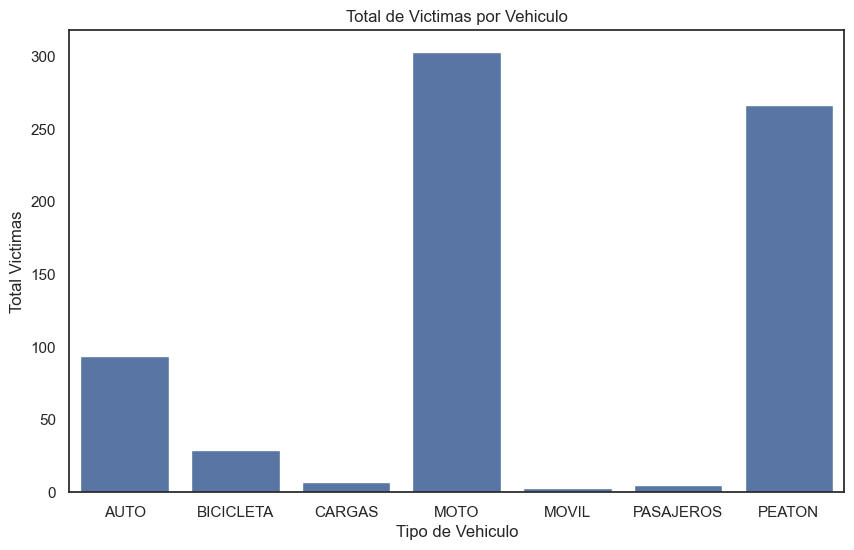

In [21]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='vehiculo_victima', y='total_homicidios', data=homicidios_por_vehiculo_victima, ax=ax)
ax.set_title('Total de Victimas por Vehiculo')
ax.set_xlabel('Tipo de Vehiculo')
ax.set_ylabel('Total Victimas')
plt.show()

#### AHORA UNA COMPARATIVA PARA CADA VEHICULO Y CADA AÑO

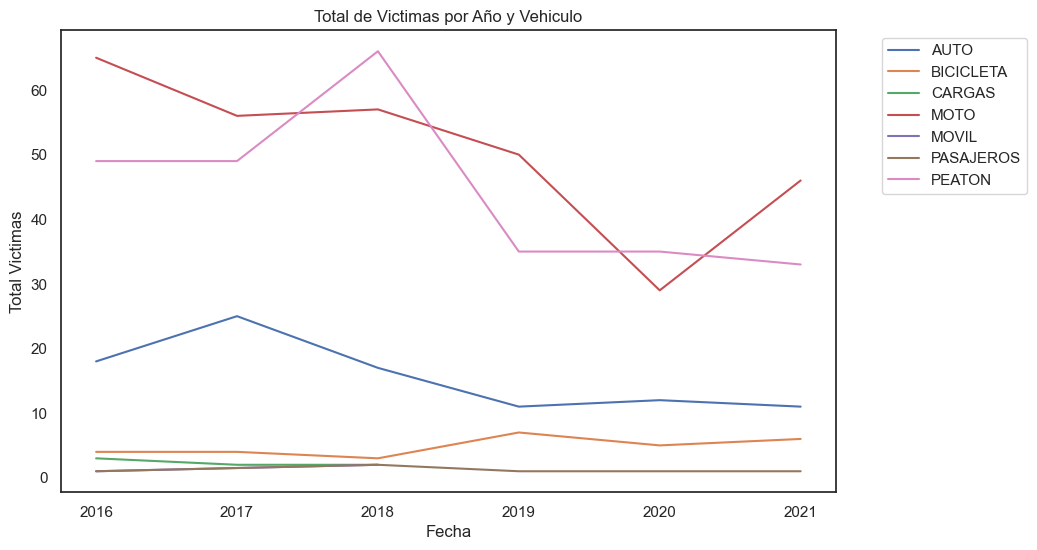

In [23]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='fecha', y='total_homicidios', hue='vehiculo_victima', data=homicidios_por_vehiculo_victima_year, ax=ax)
ax.set_title('Total de Victimas por Año y Vehiculo')
ax.set_xlabel('Fecha')
ax.set_ylabel('Total Victimas')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##### Con estos gráficos se observa que los más afectados son los motociclistas y los peatones

#### VICTIMAS POR TIPO DE CALLE

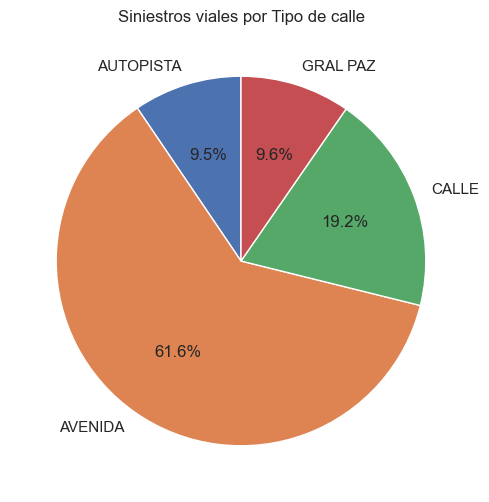

In [24]:
Homicidios_Por_Calle = df_hv.groupby(df_hv['tipo_de_calle']).size()

# Se grafica la información obtenida
plt.figure(figsize=(10, 6))
plt.pie(Homicidios_Por_Calle, labels=Homicidios_Por_Calle.index, autopct='%1.1f%%', startangle=90)

plt.title('Siniestros viales por Tipo de calle')
plt.show()

#### SE PUEDE OBSERVAR QUE HAY MUCHOS MAS ACCIDENTES EN AVENIDAS

### CREO QUE ESAS SERIAN LAS VARIBALES MAS IMPORTANTES A TENER EN CUENTA, PERO DE IGUAL FORMA HAREMOS UN ANALISIS DE LAS DEMAS

#### VARIABLESS FALTANTES

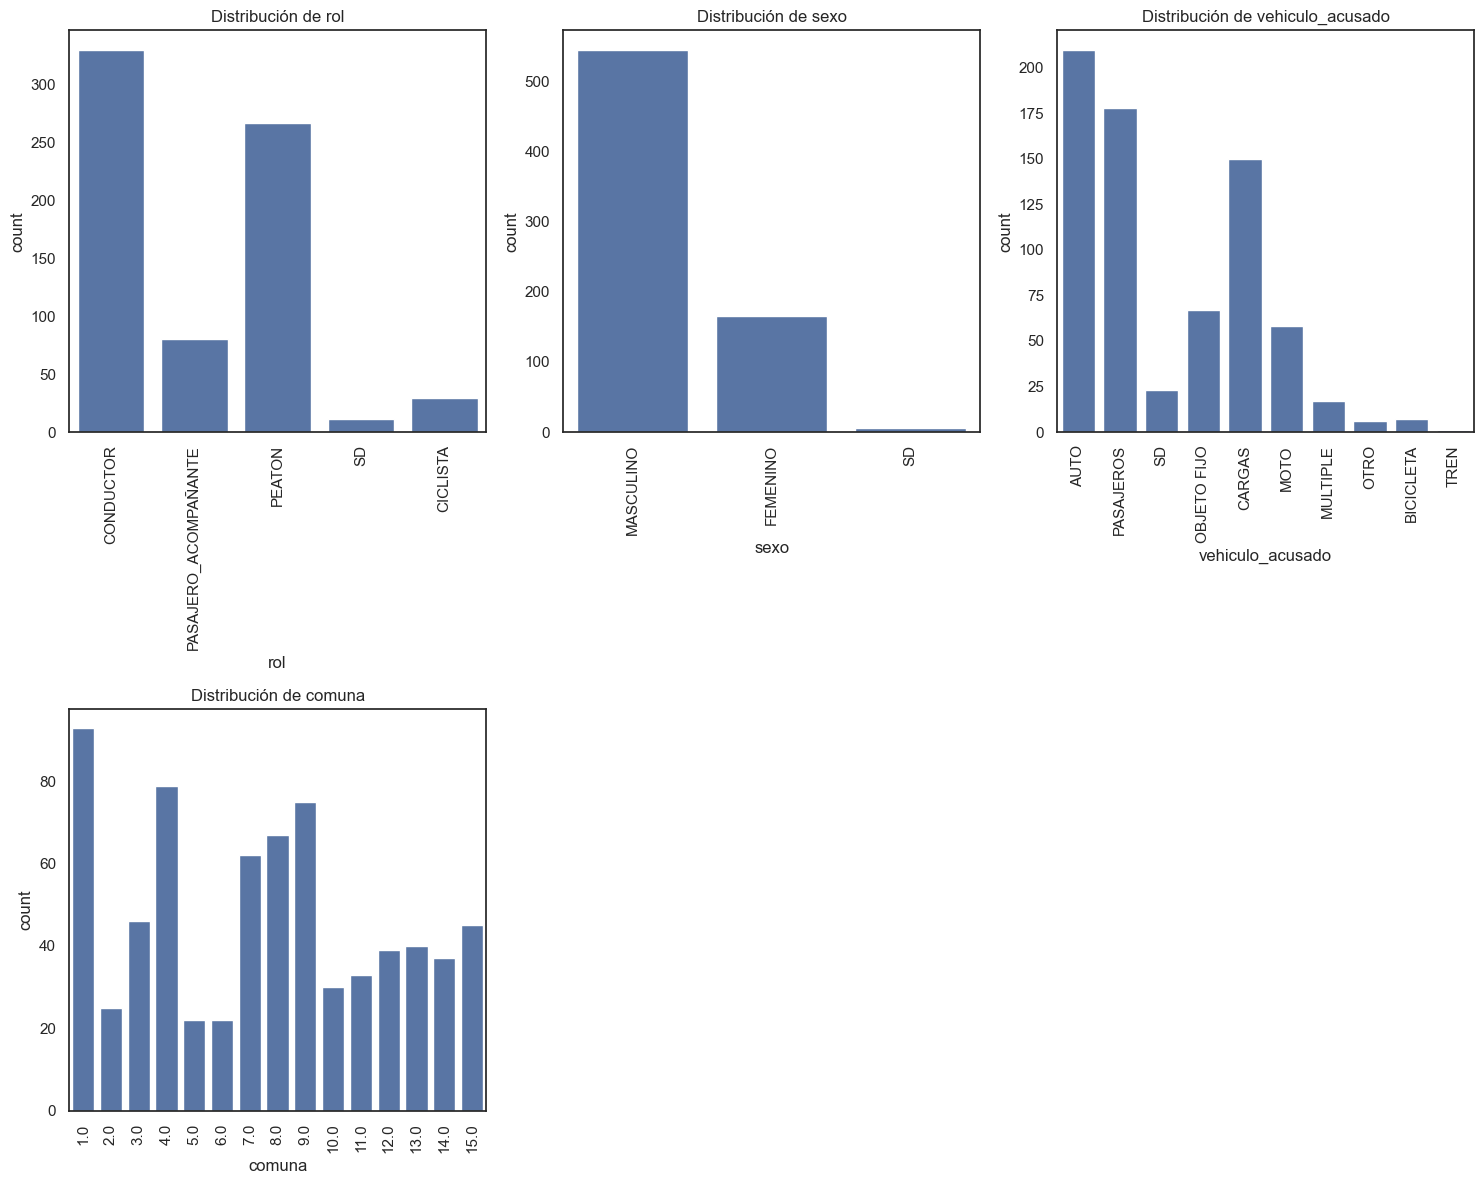

In [25]:
categoricas = ['rol','sexo', 'vehiculo_acusado', 'comuna']
plt.figure(figsize=(15, 12))
# Generación de subplots para cada columna categórica
for i, columna in enumerate(categoricas, 1):        
    plt.subplot(2, 3, i)  
    sns.countplot(data=df_hv, x=columna)
    plt.title(f'Distribución de {columna}')
    plt.xticks(rotation=90)                         
plt.tight_layout()
plt.show()

### POR ULTIMO VAMOS A VER UNA MATRIZ DE CORRELACION

In [26]:
df_hvf_cor = df_hv

le = LabelEncoder()     
# Codificación de variables categóricas
df_hvf_cor['fecha'] = le.fit_transform(df_hv['fecha'])
df_hvf_cor['rol'] = le.fit_transform(df_hv['rol'])
df_hvf_cor['sexo'] = le.fit_transform(df_hv['sexo'])
df_hvf_cor['vehiculo_victima'] = le.fit_transform(df_hv['vehiculo_victima'])
df_hvf_cor['lugar'] = le.fit_transform(df_hv['lugar'])
df_hvf_cor['tipo_de_calle'] = le.fit_transform(df_hv['tipo_de_calle'])
df_hvf_cor['vehiculo_acusado'] = le.fit_transform(df_hv['vehiculo_acusado'])

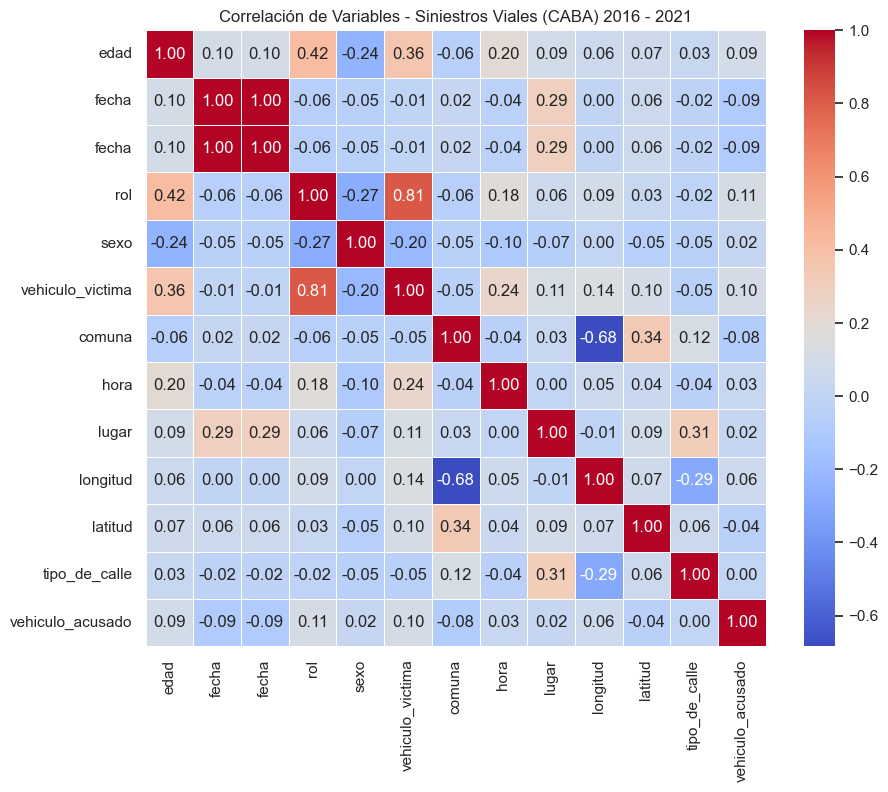

In [27]:
# Asignación de todas las variables de interés para llevar a cabo el análisis correlacional
all_variables = df_hvf_cor[['edad', 'fecha', 'fecha', 'rol',
                           'sexo', 'vehiculo_victima', 'comuna', 'hora', 'lugar', 'longitud', 'latitud', 'tipo_de_calle', 'vehiculo_acusado']]
matriz_correlacion = all_variables.corr()

# Creación gráfica para visualizar en colores la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlación de Variables - Siniestros Viales (CABA) 2016 - 2021')
plt.show()

### Conclusiones

* **Sobre información inválida o pérdida (missing):**
Únicamente fueron encontrados errores simples en datos aislados de las variables de interés: 'hora', 'longitud' y 'latitud'. Todos superados sin incidencia alguna en el análisis EDA.

* **Sobre la información de potenciales correlaciones entre las variables:**
Al respecto el ejercicio nos muestra evidencia de una fuerte relación, de '0.81' entre las variables; 'rol' y 'vehiculo_victima', reflejando la importancia que tienen tanto el vehículo de movilización, como la posición que ocupa la víctima en dicho vehículo. Esas variables, a su vez parecen mostrar algunas correlaciones, aunque muy moderada, con las edades de las víctimas ('0.42' y '0.36' respectivamente). De igual forma, la variable 'fecha' (Año del siniestro) muestra una correlación de baja intensidad con la variable 'lugar' ('0.29'), en tanto que la variable 'hora' (Hora del siniestro) tiene una relación moderada baja ('0.24') con el tipo de vehículo en el que se transporta la víctima siniestrada. Por último se evidencia una correlación baja, del '0.31' entre el lugar del siniestro (Dirección donde ocurrió el siniestro) y el tipo de vía de tránsito (Avenidas, Calles, Autopistas o Avenida General Paz).